# MBTI Prediction

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as px
from plotly import graph_objects as go

## Exploring the Data

In [2]:
data = pd.read_csv('mbti_1.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### Notes
 - There are 8675 records with no null value!

## Initial Visualization

Text(0.5, 1.0, 'Total comments for each personality type')

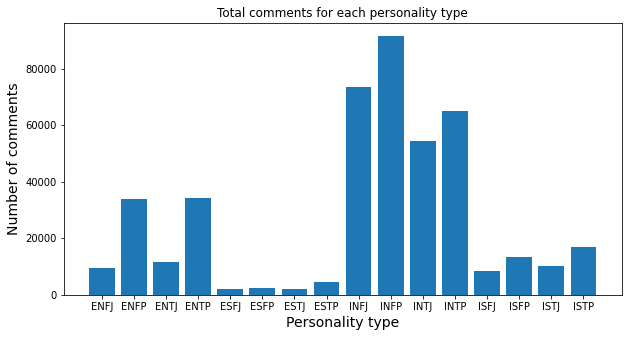

In [67]:
total_comments = data.groupby(['type']).count()*50

plt.figure(figsize = (10,5))

plt.bar(np.array(total_comments.index), height = total_comments['posts'],)
plt.xlabel('Personality type', size = 14)
plt.ylabel('Number of comments', size = 14)
plt.title('Total comments for each personality type')

### Notes
 - We see obvious difference in data available for some personality types
 - the difference between Max and Min is 46x!

# Preprocessing & Feature Engineering

In [4]:
def normalise(comment):
  comment = comment.replace('|||', '')
  comment.lower()
  comment = re.sub(r'http\S+', '', comment) # removing links
  comment = re.sub(r'\S*@\S*\s?', '', comment) # removing emails
  return(comment)

# eliminate useless words with NLTK library
def tokenize(comment):
  ignoring = nltk.corpus.stopwords.words("english") + [char for char in string.punctuation]
  tokens = nltk.word_tokenize(comment)
  tokens = [word for word in tokens if word not in ignoring]
  posTags = nltk.pos_tag(tokens)
  return posTags

def numberOfNouns(posTags):
  return len([word for word,pos in posTags if  'NN' in pos])

def numberOfVerbs(posTags):
  return len([word for word,pos in posTags if  'VB' in pos])

In [5]:
# Add new Features
data['linkPerComment'] = data['posts'].apply(lambda x: x.count('http')/50)
data['musicPerComment'] = data['posts'].apply(lambda x: x.count('music')/50)
data['questionPerComment'] = data['posts'].apply(lambda x: x.count('?')/50)
data['imagePerComment'] = data['posts'].apply(lambda x: x.count('jpg')/50)
data['exclPerComment'] = data['posts'].apply(lambda x: x.count('!')/50)
data['ellipsisPerComment'] = data['posts'].apply(lambda x: x.count('...')/50)

normalisedPosts = data['posts'].apply(lambda x: normalise(x))
data['nounsPerComment'] = normalisedPosts.apply(lambda x: numberOfNouns(tokenize(x))/50)
data['verbsPerComment'] = normalisedPosts.apply(lambda x: numberOfVerbs(tokenize(x))/50)

### Notes
 - We added 8 new features which we hope is going to improve the accuracy
 - Now Data is ready for applying models

## Training (16-Classes)

In [6]:
# Creating Train & Test data using Scikit
X = data.drop(['type','posts'], axis=1).values
y = data['type'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=5)

In [7]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
print("Random Forest Accuracy: ", acc_random_forest, "%")

Random Forest Accuracy:  19.71 %


In [8]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 41) # 41 is sqrt(x_test) 
knn.fit(X_train, y_train)

acc_knn = round(knn.score(X_test, y_test) * 100, 2)
print("KNN Accuracy: ", acc_knn, "%")

KNN Accuracy:  21.04 %


In [9]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs', max_iter=1000)
log.fit(X_train, y_train)

acc_log = round(log.score(X_test, y_test) * 100, 2)
print("Logistic Regression Accuracy: ", acc_log, "%")

Logistic Regression Accuracy:  24.96 %


In [13]:
# Neural Network
ann = MLPClassifier(hidden_layer_sizes=(200,), activation='tanh', solver='adam', learning_rate='constant', learning_rate_init=0.001, random_state=555, max_iter=1000).fit(X_train, y_train)

acc_ann = round(ann.score(X_test, y_test) * 100, 2)
print("ANN Accuracy: ", acc_ann, "%")

ANN Accuracy:  25.59 %


In [14]:
# Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
acc_naivebayes = round(gnb.score(X_test, y_test) * 100, 2)
print("Naive Bayes  Accuracy: ", acc_naivebayes, "%")

Naive Bayes  Accuracy:  21.38 %


In [15]:
# SVM-Linear

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
acc_svc = round(svclassifier.score(X_test, y_test) * 100, 2)
print("Support Vector Accuracy: ", acc_naivebayes, "%")

Support Vector Accuracy:  21.38 %


## Notes
 - Prediction is aweful with 16-Classes!

## Training (4-Classes)

### 4-Category Visualization

In [16]:
# Now we add 4 new features which represent the 4-classes
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
data['I-E'] = data['type'].astype(str).str[0]
data['I-E'] = data['I-E'].map(map1)
data['N-S'] = data['type'].astype(str).str[1]
data['N-S'] = data['N-S'].map(map2)
data['T-F'] = data['type'].astype(str).str[2]
data['T-F'] = data['T-F'].map(map3)
data['J-P'] = data['type'].astype(str).str[3]
data['J-P'] = data['J-P'].map(map4)

<BarContainer object of 8 artists>

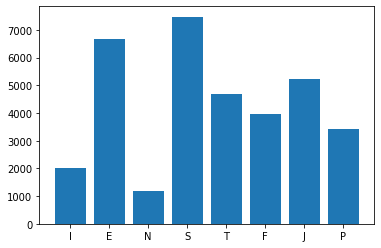

In [17]:
# We want to see how data is distributed based on 4-Classes
typeCount = {}
records_count = data.shape[0]

ICount = data['I-E'].sum()
ECount = records_count - ICount
typeCount["I"] = ICount
typeCount["E"] = ECount

ICount = data['N-S'].sum()
ECount = records_count - ICount
typeCount["N"] = ICount
typeCount["S"] = ECount

ICount = data['T-F'].sum()
ECount = records_count - ICount
typeCount["T"] = ICount
typeCount["F"] = ECount

ICount = data['J-P'].sum()
ECount = records_count - ICount
typeCount["J"] = ICount
typeCount["P"] = ECount

plt.bar(typeCount.keys(), typeCount.values())

### Notes
 - there is still notable difference, but it's more balanced now!

In [18]:
# Creating Train & Test data using Scikit

# Introvert vs Extrovert
X_IE = data.drop(['type','posts','I-E'], axis=1).values
y_IE = data['I-E'].values
X_IE_train,X_IE_test,y_IE_train,y_IE_test = train_test_split(X_IE,y_IE,test_size = 0.2, random_state=5)

# Intuition vs Sensing
X_NS = data.drop(['type','posts','N-S'], axis=1).values
y_NS = data['N-S'].values
X_NS_train,X_NS_test,y_NS_train,y_NS_test = train_test_split(X_NS,y_NS,test_size = 0.2, random_state=5)

# Thinking - Feeling
X_TF = data.drop(['type','posts','T-F'], axis=1).values
y_TF = data['T-F'].values
X_TF_train,X_TF_test,y_TF_train,y_TF_test = train_test_split(X_TF,y_TF,test_size = 0.2, random_state=5)

# Judging - Percieiving
X_JP = data.drop(['type','posts','J-P'], axis=1).values
y_JP = data['J-P'].values
X_JP_train,X_JP_test,y_JP_train,y_JP_test = train_test_split(X_JP,y_JP,test_size = 0.2, random_state=5)

In [69]:
#ANN
IEClass = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, random_state=555, max_iter=1000).fit(X_IE_train, y_IE_train)
NSClass = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, random_state=555, max_iter=1000).fit(X_NS_train, y_NS_train)
TFClass = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, random_state=555, max_iter=1000).fit(X_TF_train, y_TF_train)
JPClass = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, random_state=555, max_iter=1000).fit(X_JP_train, y_JP_train)

acc_ANN_IE = round(IEClass.score(X_IE_test, y_IE_test) * 100, 2)
acc_ANN_NS = round(NSClass.score(X_NS_test, y_NS_test) * 100, 2)
acc_ANN_TF = round(TFClass.score(X_TF_test, y_TF_test) * 100, 2)
acc_ANN_JP = round(JPClass.score(X_JP_test, y_JP_test) * 100, 2)
mean_acc_ann = round((acc_ANN_IE + acc_ANN_NS + acc_ANN_TF + acc_ANN_JP)/4, 2)

print("I-E Accuracy: ", acc_ANN_IE, "%")
print("N-S Accuracy: ", acc_ANN_NS, "%")
print("T-F Accuracy: ", acc_ANN_TF, "%")
print("J-P Accuracy: ", acc_ANN_JP, "%")
print("mean Accuracy: ", mean_acc_ann , "%")

records_count = len(X_IE_test)

predicted = np.concatenate((np.array(IEClass.predict(X_IE_test)),np.array(NSClass.predict(X_NS_test)),np.array(TFClass.predict(X_TF_test)),np.array(JPClass.predict(X_JP_test))))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)
act_acc_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy:  77.69 %
N-S Accuracy:  86.86 %
T-F Accuracy:  68.13 %
J-P Accuracy:  60.81 %
mean Accuracy:  73.37 %
Actuall Accuracy (pint to point):  33.78 %
1-miss Accuracy (pint to point):  68.88 %


In [57]:
# Random Forest
random_forest = RandomForestClassifier()

# I-E
random_forest.fit(X_IE_train, y_IE_train)
acc_random_forest_IE = round(random_forest.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy: ", acc_random_forest_IE, "%")

iep = np.array(random_forest.predict(X_IE_test))

# N-S
random_forest.fit(X_IE_train, y_NS_train)
acc_random_forest_NS = round(random_forest.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy: ", acc_random_forest_NS, "%")

nsp = np.array(random_forest.predict(X_NS_test))

# T-F
random_forest.fit(X_TF_train, y_TF_train)
acc_random_forest_TF = round(random_forest.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy: ", acc_random_forest_TF, "%")

tfp = np.array(random_forest.predict(X_TF_test))

# J-P
random_forest.fit(X_JP_train, y_JP_train)
acc_random_forest_JP = round(random_forest.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy: ", acc_random_forest_JP, "%")

jpp = np.array(random_forest.predict(X_JP_test))

mean_acc_random_forest = (acc_random_forest_IE + acc_random_forest_NS + acc_random_forest_TF + acc_random_forest_JP)/4
print("mean Accuracy: ", mean_acc_random_forest , "%")



records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_rf_ann = round((sum(complete == 4) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_rf_ann, "%")

I-E Accuracy:  77.23 %
N-S Accuracy:  68.88 %
T-F Accuracy:  64.44 %
J-P Accuracy:  56.83 %
mean Accuracy:  66.845 %
Actuall Accuracy (pint to point):  22.88 %


In [70]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 41)

# I-E
knn.fit(X_IE_train, y_IE_train)
acc_knn_IE = round(knn.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy: ", acc_knn_IE, "%")

iep = np.array(knn.predict(X_IE_test))

# N-S
knn.fit(X_NS_train, y_NS_train)
acc_knn_NS = round(knn.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy: ", acc_knn_NS, "%")

nsp = np.array(knn.predict(X_NS_test))

# T-F
knn.fit(X_TF_train, y_TF_train)
acc_knn_TF = round(knn.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy: ", acc_knn_TF, "%")

tfp = np.array(knn.predict(X_TF_test))

# J-P
knn.fit(X_JP_train, y_JP_train)
acc_knn_JP = round(knn.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy: ", acc_knn_JP, "%")

jpp = np.array(knn.predict(X_JP_test))

mean_acc_knn = (acc_knn_IE + acc_knn_NS + acc_knn_TF + acc_knn_JP)/4
print("mean Accuracy: ", mean_acc_knn , "%")


records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_knn_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy:  77.64 %
N-S Accuracy:  86.86 %
T-F Accuracy:  59.65 %
J-P Accuracy:  59.48 %
mean Accuracy:  70.9075 %
Actuall Accuracy (pint to point):  33.78 %
1-miss Accuracy (pint to point):  64.38 %


In [71]:
# Logistic Regression

log = LogisticRegression(solver='lbfgs', max_iter=1000)

# I-E
log.fit(X_IE_train, y_IE_train)
acc_log_IE = round(log.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy: ", acc_log_IE, "%")

iep = np.array(log.predict(X_IE_test))

# N-S
log.fit(X_NS_train, y_NS_train)
acc_log_NS = round(log.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy: ", acc_log_NS, "%")

nsp = np.array(log.predict(X_NS_test))

# T-F
log.fit(X_TF_train, y_TF_train)
acc_log_TF = round(log.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy: ", acc_log_TF, "%")

tfp = np.array(log.predict(X_TF_test))

# J-P
log.fit(X_JP_train, y_JP_train)
acc_log_JP = round(log.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy: ", acc_log_JP, "%")

jpp = np.array(log.predict(X_JP_test))

mean_acc_log = (acc_log_IE + acc_log_NS + acc_log_TF + acc_log_JP)/4
print("mean Accuracy: ", mean_acc_log , "%")

records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_log_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy:  77.58 %
N-S Accuracy:  86.86 %
T-F Accuracy:  66.74 %
J-P Accuracy:  60.46 %
mean Accuracy:  72.91 %
Actuall Accuracy (pint to point):  33.78 %
1-miss Accuracy (pint to point):  68.3 %


In [76]:
# Naive Bayes
gnb = GaussianNB()

# I-E
gnb.fit(X_IE_train, y_IE_train)
acc_nb_IE = round(gnb.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy:", acc_nb_IE, "%")

iep = np.array(gnb.predict(X_IE_test))

# N-S
gnb.fit(X_NS_train, y_NS_train)
acc_nb_NS = round(gnb.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy:", acc_nb_NS, "%")

nsp = np.array(gnb.predict(X_NS_test))

# T-F
gnb.fit(X_TF_train, y_TF_train)
acc_nb_TF = round(gnb.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy:", acc_nb_TF, "%")

tfp = np.array(gnb.predict(X_TF_test))

# J-P
gnb.fit(X_JP_train, y_JP_train)
acc_nb_JP = round(gnb.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy:", acc_nb_JP, "%")

jpp = np.array(gnb.predict(X_JP_test))

mean_acc_gnb = (acc_nb_IE + acc_nb_NS + acc_nb_TF + acc_nb_JP)/4
print("mean Accuracy: ", mean_acc_gnb , "%")


records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_nb_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy: 76.31 %
N-S Accuracy: 83.86 %
T-F Accuracy: 62.07 %
J-P Accuracy: 57.12 %
mean Accuracy:  69.84 %
Actuall Accuracy (pint to point):  33.78 %
1-miss Accuracy (pint to point):  64.32 %


In [77]:
# SVM-Linear
svclassifier = SVC(kernel='linear')

# I-E
svclassifier.fit(X_IE_train, y_IE_train)
acc_svc_IE = round(svclassifier.score(X_IE_test, y_IE_test) * 100, 2)
print("I-E Accuracy:", acc_nb_IE, "%")

iep = np.array(svclassifier.predict(X_IE_test))

# N-S
svclassifier.fit(X_NS_train, y_NS_train)
acc_svc_NS = round(svclassifier.score(X_NS_test, y_NS_test) * 100, 2)
print("N-S Accuracy:", acc_nb_NS, "%")

nsp = np.array(svclassifier.predict(X_NS_test))

# T-F
svclassifier.fit(X_TF_train, y_TF_train)
acc_svc_TF = round(svclassifier.score(X_TF_test, y_TF_test) * 100, 2)
print("T-F Accuracy:", acc_nb_TF, "%")

tfp = np.array(svclassifier.predict(X_TF_test))

# J-P
svclassifier.fit(X_JP_train, y_JP_train)
acc_svc_JP = round(svclassifier.score(X_JP_test, y_JP_test) * 100, 2)
print("J-P Accuracy:", acc_nb_JP, "%")

jpp = np.array(svclassifier.predict(X_JP_test))

mean_acc_svc = (acc_nb_IE + acc_nb_NS + acc_nb_TF + acc_nb_JP)/4
print("mean Accuracy: ", mean_acc_svc , "%")


records_count = len(X_IE_test)

predicted = np.concatenate((iep,nsp,tfp,jpp))
predicted = np.reshape(predicted,(records_count,4))

y_total = np.concatenate((np.array(y_IE_test),np.array(y_NS_test),np.array(y_TF_test),np.array(y_JP_test)))
y_total = np.reshape(y_total,(records_count,4))

acc = predicted == y_total
complete = np.sum(acc,axis=1)

act_svc_ann = round((sum(complete == 4) / records_count)*100, 2)
three_acc_ann = round((sum(complete >= 3) / records_count)*100, 2)

print("Actuall Accuracy (pint to point): ", act_acc_ann, "%")
print("1-miss Accuracy (pint to point): ", three_acc_ann, "%")

I-E Accuracy: 76.31 %
N-S Accuracy: 83.86 %
T-F Accuracy: 62.07 %
J-P Accuracy: 57.12 %
mean Accuracy:  69.84 %
Actuall Accuracy (pint to point):  33.78 %
1-miss Accuracy (pint to point):  68.13 %


In [78]:
# Lets see which model perform better visually!

# set heights of bars
bars1 = [acc_ANN_IE , acc_ANN_NS , acc_ANN_TF , acc_ANN_JP, mean_acc_ann, act_acc_ann]
bars2 = [acc_random_forest_IE , acc_random_forest_NS , acc_random_forest_TF , acc_random_forest_JP, mean_acc_random_forest, act_rf_ann]
bars3 = [acc_knn_IE , acc_knn_NS , acc_knn_TF , acc_knn_JP, mean_acc_knn, act_knn_ann]
bars4 = [acc_log_IE , acc_log_NS , acc_log_TF , acc_log_JP, mean_acc_log, act_log_ann]
bars5 = [acc_nb_IE , acc_nb_NS , acc_nb_TF , acc_nb_JP, mean_acc_gnb, act_nb_ann]
bars6 = [acc_svc_IE , acc_svc_NS , acc_svc_TF , acc_svc_JP, mean_acc_svc, act_svc_ann]

x = ['I-E', 'N-S', 'T-F', 'J-P', 'mean', 'actual']
  
plot = px.Figure(data=[
    go.Bar(name = 'ANN', x = x, y = bars1),
    go.Bar(name = 'Random Forest', x = x, y = bars2),
    go.Bar(name = 'KNN', x = x, y = bars3),
    go.Bar(name = 'Logistic Regression', x = x, y = bars4),
    go.Bar(name = 'Naive Bayes', x = x, y = bars5),
    go.Bar(name = 'SVM', x = x, y = bars6),
])
                   
plot.show()

## Notes
 - Now Accuracy is much better for each class